In [1]:
import re
from datasets import load_from_disk

from src._shared import load_tokenizers, load_config

Matplotlib created a temporary cache directory at /tmp/matplotlib-_d2puoij because the default path (/home/lfi/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
config = load_config()
tokenizer_plm, tokenizer_llm = load_tokenizers(config)

In [3]:
dataset_path = "../tmp/data/unprocessed/protein_go_concatenated_random_7_3"
dataset_path_processed = "../tmp/data/processed/protein_go_concatenated_random_7_3"

dataset = load_from_disk(dataset_path)

In [4]:
print(dataset)
print(dataset['train'][2])

DatasetDict({
    train: Dataset({
        features: ['proteins', 'sequences', 'sentences'],
        num_rows: 54487
    })
    test: Dataset({
        features: ['proteins', 'sequences', 'sentences'],
        num_rows: 6055
    })
})
{'proteins': 'P51693', 'sequences': 'MGPASPAARGLSRRPGQPPLPLLLPLLLLLLRAQPAIGSLAGGSPGAAEAPGSAQVAGLCGRLTLHRDLRTGRWEPDPQRSRRCLRDPQRVLEYCRQMYPELQIARVEQATQAIPMERWCGGSRSGSCAHPHHQVVPFRCLPGEFVSEALLVPEGCRFLHQERMDQCESSTRRHQEAQEACSSQGLILHGSGMLLPCGSDRFRGVEYVCCPPPGTPDPSGTAVGDPSTRSWPPGSRVEGAEDEEEEESFPQPVDDYFVEPPQAEEEEETVPPPSSHTLAVVGKVTPTPRPTDGVDIYFGMPGEISEHEGFLRAKMDLEERRMRQINEVMREWAMADNQSKNLPKADRQALNEHFQSILQTLEEQVSGERQRLVETHATRVIALINDQRRAALEGFLAALQADPPQAERVLLALRRYLRAEQKEQRHTLRHYQHVAAVDPEKAQQMRFQVHTHLQVIEERVNQSLGLLDQNPHLAQELRPQIQELLHSEHLGPSELEAPAPGGSSEDKGGLQPPDSKDDTPMTLPKGSTEQDAASPEKEKMNPLEQYERKVNASVPRGFPFHSSEIQRDELAPAGTGVSREAVSGLLIMGAGGGSLIVLSMLLLRRKKPYGAISHGVVEVDPMLTLEEQQLRELQRHGYENPTYRFLEERP', 'sentences': 'Relevant to: cellular response to organonitrogen compound, nu

In [5]:
identifier_sequence = "sequences"
identifier_text = "sentences"

for split in dataset:
    dataset[split] = dataset[split].rename_column("proteins", "identifier")
    dataset[split] = dataset[split] = dataset[split].filter(lambda x: len(x[identifier_sequence]) < 256)
    processed_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", seq))) for seq in dataset[split][identifier_sequence]]
    dataset[split] = dataset[split].add_column("sequence_processed", processed_sequences)
    
    processed_texts = [text.replace("Relevant to: ", "") for text in dataset[split][identifier_text]]
    dataset[split] = dataset[split].remove_columns(identifier_text)
    dataset[split] = dataset[split].add_column('processed_texts', processed_texts)

    tknz_plm = tokenizer_plm(text=dataset[split]["sequence_processed"], padding=False, truncation=False)
    tknz_llm = tokenizer_llm(text=dataset[split]["processed_texts"], padding=False, truncation=False)

    dataset[split] = dataset[split].add_column("input_ids_sequence", tknz_plm["input_ids"])
    dataset[split] = dataset[split].add_column("attention_mask_sequence", tknz_plm["attention_mask"])
    dataset[split] = dataset[split].add_column("input_ids_text", tknz_llm["input_ids"])
    dataset[split] = dataset[split].add_column("attention_mask_text", tknz_llm["attention_mask"])
    
    dataset[split] = dataset[split].filter(lambda x: len(x['input_ids_text']) < 256)


Filter:   0%|          | 0/18023 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
print(dataset)
print(dataset['train'][1])

DatasetDict({
    train: Dataset({
        features: ['identifier', 'sequences', 'sequence_processed', 'processed_texts', 'input_ids_sequence', 'attention_mask_sequence', 'input_ids_text', 'attention_mask_text'],
        num_rows: 18023
    })
    test: Dataset({
        features: ['identifier', 'sequences', 'sequence_processed', 'processed_texts', 'input_ids_sequence', 'attention_mask_sequence', 'input_ids_text', 'attention_mask_text'],
        num_rows: 2000
    })
})
{'identifier': 'Q76MS9', 'sequences': 'MSQPDPVKKKRPPVKEEDLKGARGNLSKNQEIKSKTYQVMKQCEQMGSAAPSIFSRARTGSETVFEKSKDEPPKSVFG', 'sequence_processed': 'M S Q P D P V K K K R P P V K E E D L K G A R G N L S K N Q E I K S K T Y Q V M K Q C E Q M G S A A P S I F S R A R T G S E T V F E K S K D E P P K S V F G', 'processed_texts': 'intracellular anatomical structure, nucleus, intracellular membrane-bounded organelle, organelle, intracellular organelle, membrane-bounded organelle, cellular anatomical entity, cellular_component.', 'in

In [7]:
dataset.save_to_disk(dataset_path_processed)

Saving the dataset (0/1 shards):   0%|          | 0/18023 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

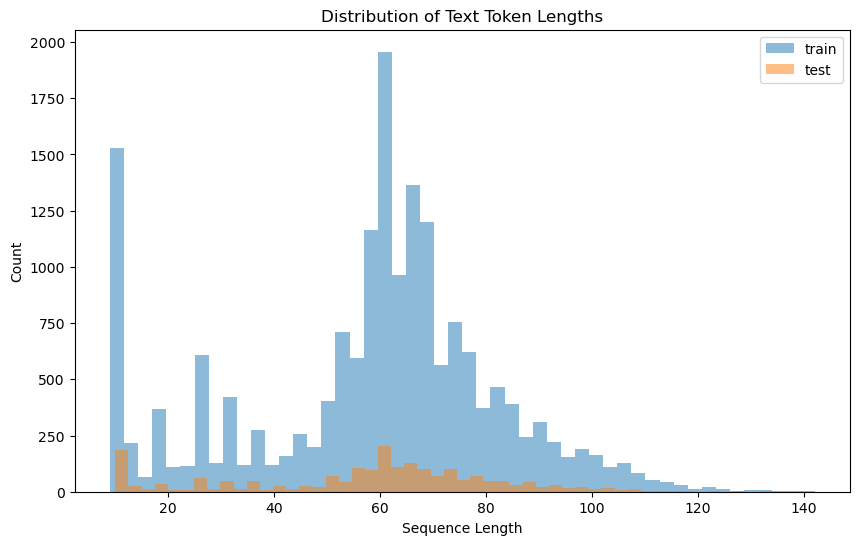

: 

In [8]:
import matplotlib.pyplot as plt

# Calculate lengths for each split
lengths = {}
for split in dataset:
    lengths[split] = [len(ids) for ids in dataset[split]['input_ids_text']]

# Create the plot
plt.figure(figsize=(10, 6))
for split, split_lengths in lengths.items():
    plt.hist(split_lengths, bins=50, alpha=0.5, label=split)

plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Text Token Lengths')
plt.legend()
plt.show()
